Diamond Price Prediction using XGBoost  
This notebook predicts diamond prices using the Kaggle Diamonds dataset.  
The notebook covers:
- Data loading and importing requirements
- Data preprocessing 
- Training an XGBoost regressor
- Model evaluation
- Model explanation using SHAP

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import shap
import seaborn as sns

## Data Loading and Exploration

In [56]:
diamonds = pd.read_csv('diamonds.csv')
diamonds

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


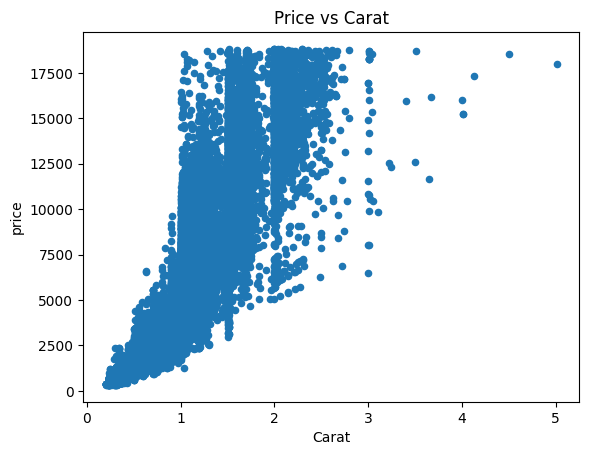

In [57]:
# Data exploration - Scatter plot of 'Price vs Carat'
diamonds.plot(kind='scatter', x='carat', y='price', title='Price vs Carat')
plt.xlabel("Carat")
plt.ylabel("price")
plt.show()

## Preprocessing data:

- separating the training set and the target variable

In [58]:
y = diamonds['price']
y

0         326
1         326
2         327
3         334
4         335
         ... 
53935    2757
53936    2757
53937    2757
53938    2757
53939    2757
Name: price, Length: 53940, dtype: int64

In [59]:
training_set = diamonds.drop('price', axis=1)
training_set

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74


In [60]:
training_set.set_index('Unnamed: 0', inplace=True)

In [61]:
training_set.rename_axis('index', inplace=True)
training_set

,carat,cut,color,clarity,depth,table,x,y,z
index,,,,,,,,,
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56


- Encoding categorial features using one-hot encoding to make them suitable for regression.  
Each category is organized by value for consistency.

In [62]:
enc = preprocessing.OrdinalEncoder()

In [63]:
enc = OrdinalEncoder(categories=[["Ideal","Premium","Very Good","Good","Fair"]])
training_set[['cut']] = enc.fit_transform(training_set[['cut']])
enc = OrdinalEncoder(categories=[["IF","VVS1","VVS2","VS1","VS2","SI1","SI2","I1"]])
training_set[['clarity']] = enc.fit_transform(training_set[['clarity']])
enc = OrdinalEncoder(categories=[["D","E","F","G","H","I","J"]])
training_set[["color"]] = enc.fit_transform(training_set[["color"]])
training_set

,carat,cut,color,clarity,depth,table,x,y,z
index,,,,,,,,,
1,0.23,0.0,1.0,6.0,61.5,55.0,3.95,3.98,2.43
2,0.21,1.0,1.0,5.0,59.8,61.0,3.89,3.84,2.31
3,0.23,3.0,1.0,3.0,56.9,65.0,4.05,4.07,2.31
4,0.29,1.0,5.0,4.0,62.4,58.0,4.20,4.23,2.63
5,0.31,3.0,6.0,6.0,63.3,58.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...
53936,0.72,0.0,0.0,5.0,60.8,57.0,5.75,5.76,3.50
53937,0.72,3.0,0.0,5.0,63.1,55.0,5.69,5.75,3.61
53938,0.70,2.0,0.0,5.0,62.8,60.0,5.66,5.68,3.56


- Feature engineering  
created a new feature 'Volume = x * y * z' to capture the diamond's size in 3D

In [64]:
training_set['volume'] = training_set['x'] * training_set['y'] * training_set['z']
training_set

,carat,cut,color,clarity,depth,table,x,y,z,volume
index,,,,,,,,,,
1,0.23,0.0,1.0,6.0,61.5,55.0,3.95,3.98,2.43,38.202030
2,0.21,1.0,1.0,5.0,59.8,61.0,3.89,3.84,2.31,34.505856
3,0.23,3.0,1.0,3.0,56.9,65.0,4.05,4.07,2.31,38.076885
4,0.29,1.0,5.0,4.0,62.4,58.0,4.20,4.23,2.63,46.724580
5,0.31,3.0,6.0,6.0,63.3,58.0,4.34,4.35,2.75,51.917250
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,0.0,0.0,5.0,60.8,57.0,5.75,5.76,3.50,115.920000
53937,0.72,3.0,0.0,5.0,63.1,55.0,5.69,5.75,3.61,118.110175
53938,0.70,2.0,0.0,5.0,62.8,60.0,5.66,5.68,3.56,114.449728


- Applying log transformation on the target variable
- The price distribution is highly skewed. Applying a log transformation stabilizes variance and improves model's performance.

Text(0.5, 1.0, 'Original Price distribution')

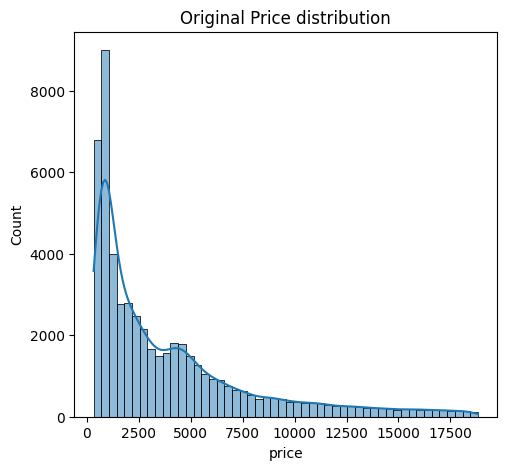

In [65]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(y, bins=50, kde=True)
plt.title("Original Price distribution")

In [66]:
y_l = np.log(y)

Text(0.5, 1.0, 'Price distribution after log transformation')

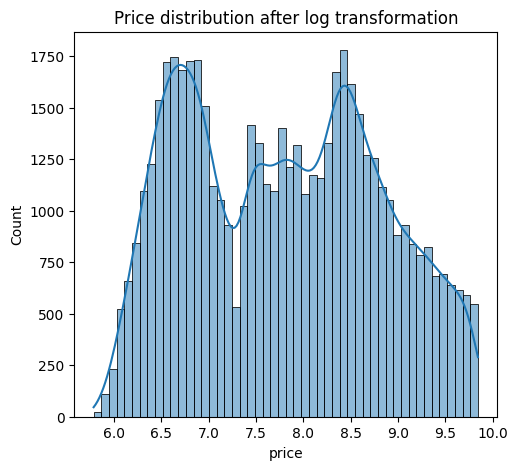

In [67]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(y_l, bins=50, kde=True)
plt.title("Price distribution after log transformation")

## Train-Test split
- Spliting the data set into training set(80%) and test set(20%)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(training_set, y_l, test_size=0.2, random_state=42)

In [69]:
x_train.shape

(43152, 10)

In [70]:
x_test.shape

(10788, 10)

In [71]:
y_test.shape

(10788,)

## Model Training and Evaluation
1. Train-Test Evaluation:  
- Training an XGBoost regressor on the training set and evaluating on the test set.  
- **Metrics:**  
  R2 score: Measures proportion of variance explained by the model.  
  Mean Squared Error(MSE): Measures average squared prediction error

In [72]:
model = XGBRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [73]:
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print(f"mean squared error is {mse}")
print(f"r2 score is {r2}")

mean squared error is 0.007778690923311669
r2 score is 0.9924229491783884


### Cross-Validation Evaluation:
Performed 5-fold cross-validation for a robust estimate of model performance.

In [74]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, training_set, y_l, cv=cv, scoring='r2')
print("scores: ", scores)
print("mean scores: ", scores.mean())

scores:  [0.99245885 0.99208351 0.99209164 0.9924284  0.9926573 ]
mean scores:  0.9923439387837206


## Model Explainability with SHAP
SHAP was used to explain the XGBoost model, with summary and waterfall plots showing global feature importance and local prediction explanations.

In [75]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(x_test)

### Summary plot:
- Shows the most important features across the dataset and how they affect price prediction.
- Each dot represents one diamond.
- The x-axis shows how much a feature pushed the prediction higher or lower.

In [76]:
shap.summery_plot = (shap_values, x_test)

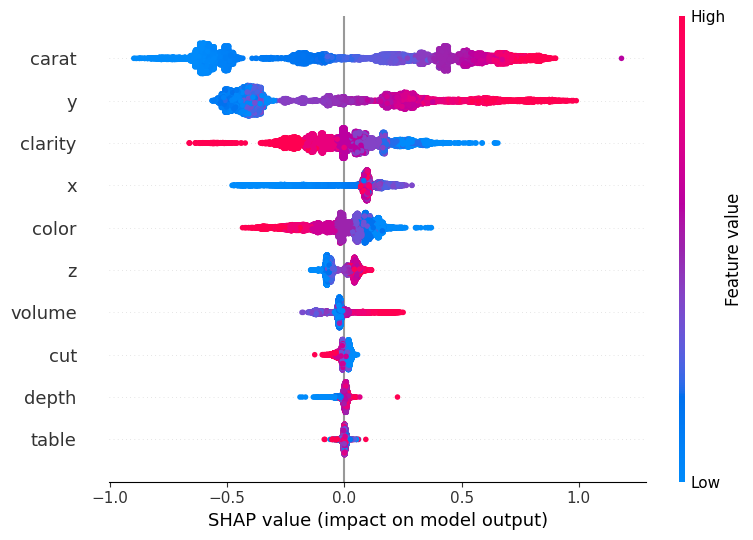

In [77]:
shap.summary_plot(shap_values, x_test)

### Waterfall plot:
- Explains how individual features contributed to one specific prediction.

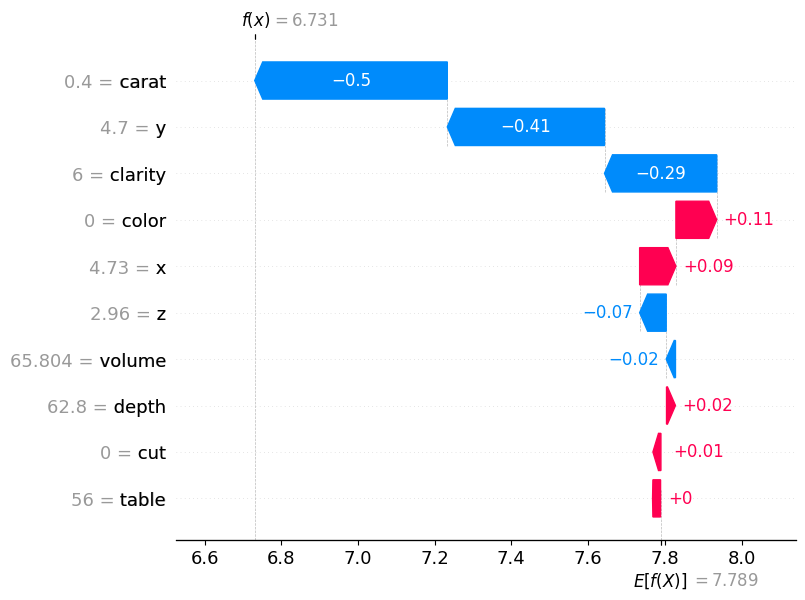

In [78]:
shap_values = explainer(x_test)
shap.waterfall_plot(shap_values[10])

## Conclusion
- XGBoost achieved high accuracy (mean-r2 score ~ 0.992)
- Important features include 'Carat', 'y' and 'Clarity'.
- SHAP analysis confirms that higher carat and volume increase the price, while lower clarity can decrease it.
- The model is interpretable, robust and ready for further experimentation.